In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd



columns = ["age" ,      
      "sex"    ,
      "chest pain type"  ,       
      "resting blood pressure" ,
      "serum cholestoral in mg/dl",      
      "fasting blood sugar > 120 mg/dl",       
      "resting electrocardiographic results",  
      "maximum heart rate achieved" , 
      "exercise induced angina"    ,
      "oldpeak = ST depression induced by exercise relative to rest"  , 
      "the slope of the peak exercise ST segment"     ,
      "number of major vessels (0-3) colored by flourosopy",        
       "thal", "target"]
data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat",header=None, sep=" ")
data.columns=columns

categorical_columns = ['sex', 'chest pain type','fasting blood sugar > 120 mg/dl',"resting electrocardiographic results","thal","exercise induced angina"]

for c in categorical_columns:
      data[c] = data[c].astype('category')
else:
      data[c] = data[c].astype(float)

data["target"] = np.where(data["target"]==2,1,0)

features = [c for c in columns if c !='target']
X = data[features]




y = data['target']

In [4]:
X

,age,sex,chest pain type,resting blood pressure,serum cholestoral in mg/dl,fasting blood sugar > 120 mg/dl,resting electrocardiographic results,maximum heart rate achieved,exercise induced angina,oldpeak = ST depression induced by exercise relative to rest,the slope of the peak exercise ST segment,number of major vessels (0-3) colored by flourosopy,thal
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [6]:
from scorepyo.preprocessing import AutoBinarizer


binarizer = AutoBinarizer(max_number_binaries_by_features=3, keep_negative=True)
binarizer.fit(X_train, y_train, categorical_features=categorical_columns, to_exclude_features=None)

X_train_binarized = binarizer.transform_bis(X_train)
X_test_binarized, _ = binarizer.transform(X_test)

In [7]:
# binarizer.df_score_feature

In [29]:
from scorepyo.models import EBMRiskScore, OptunaRiskScore

ebm_model = EBMRiskScore()
# scorepyo_model = OptunaRiskScore(
#     # df_info=df_info["feature"].reset_index()
# )

# scorepyo_model.fit(X_train_binarized, y_train)
ebm_model.fit(X_train, y_train, categorical_features=categorical_columns)

	 1.7264597459655517
	 1.723312695597514
	 1.7206585283640297
	 1.673366603384031
	 1.6728818564457826
	 1.67267348214218
	 1.6526422378149142
	 1.6506757159834364
	 1.6278383893174981


The Risk Score is:
1.                             the slope of the peak exercise ST segment < 1.5     -1 point(s) |   ...
2.                   number of major vessels (0-3) colored by flourosopy < 0.5     -1 point(s) | + ...
3.                                                         chest pain type_4.0      1 point(s) | + ...
4.                                                                    thal_7.0      1 point(s) | + ...
                                                                                         SCORE | =

('number of major vessels (0-3) colored by flourosopy < 0.5', 'chest pain type_4.0', 'thal_7.0', 'the slope of the peak exercise ST segment < 1.5')

In [30]:
ebm_model.summary()

| FEATURE-POINT CARD |
| Feature                                                   | Description                                               | Point(s)   |       |
|:----------------------------------------------------------|:----------------------------------------------------------|:-----------|:------|
| the slope of the peak exercise ST segment < 1.5           | the slope of the peak exercise ST segment < 1.5           | -1         | ...   |
| number of major vessels (0-3) colored by flourosopy < 0.5 | number of major vessels (0-3) colored by flourosopy < 0.5 | -1         | + ... |
| chest pain type_4.0                                       | chest pain type_4.0                                       | 1          | + ... |
| thal_7.0                                                  | thal_7.0                                                  | 1          | + ... |
|                                                           |                                                          

In [32]:
import itertools

def nb_solutions(nb_total_features, min_point_value, max_point_value, nb_selected_features):
    range_ = max_point_value-min_point_value
    if min_point_value<0:
        range_-=1
    return (nb_total_features*range_)**nb_selected_features

for i in range(5,16):
    print(len(list(itertools.combinations(range(4+i), 4))))

126
210
330
495
715
1001
1365
1820
2380
3060
3876


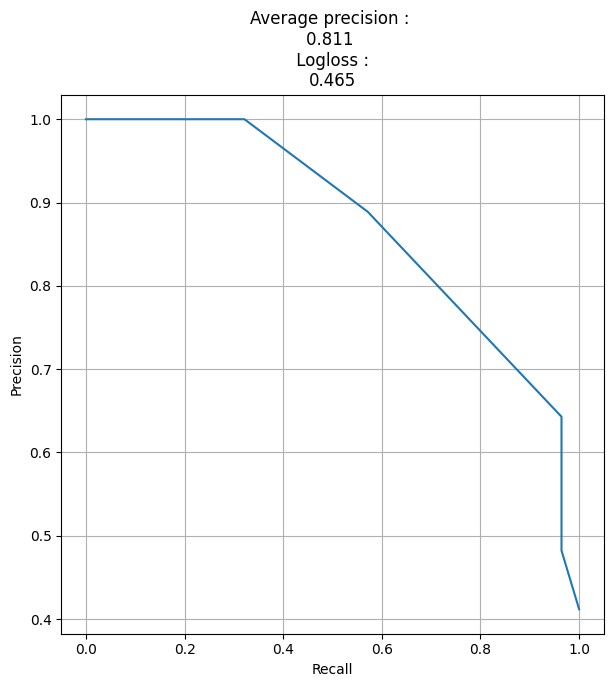

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss


y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [12]:
from scorepyo.models import OptunaRiskScore


scorepyo_model = OptunaRiskScore(
    nb_max_features=4,
    min_point_value=-1,
    max_point_value=2,
    # df_info=df_info["feature"].reset_index(),
    optuna_optimize_params={"n_trials":100, "timeout":30}
)

# print('Number of combinations:',scorepyo_model.nb_max_features**(X.shape[1]*(scorepyo_model.max_point_value-scorepyo_model.min_point_value)))

In [13]:


scorepyo_model.fit(X_train_binarized, y_train)

In [14]:
scorepyo_model.summary()

| FEATURE-POINT CARD |
| Feature                                                              | Description                                                          | Point(s)   |       |
|:---------------------------------------------------------------------|:---------------------------------------------------------------------|:-----------|:------|
| number of major vessels (0-3) colored by flourosopy < 0.5            | number of major vessels (0-3) colored by flourosopy < 0.5            | -1         | ...   |
| age < 50.5                                                           | age < 50.5                                                           | -1         | + ... |
| chest pain type_4.0                                                  | chest pain type_4.0                                                  | 1          | + ... |
| oldpeak = ST depression induced by exercise relative to rest >= 1.35 | oldpeak = ST depression induced by exercise relative to rest >= 1.35 | 2       

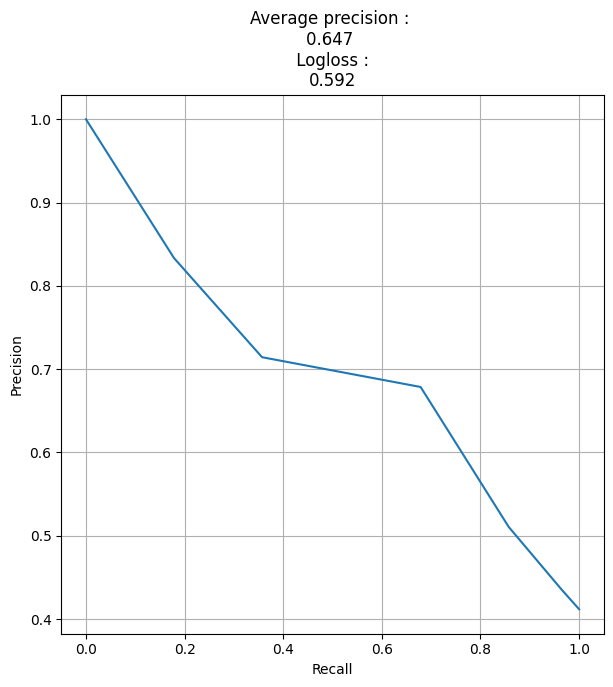

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss


y_proba = scorepyo_model.predict_proba(X_test_binarized)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [16]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(scorepyo_model._study)

In [17]:
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier

sparsity = 4
parent_size = 10
y_train_fasterrisk = np.where(y_train==0,-1,1)
RiskScoreOptimizer_m = RiskScoreOptimizer(X = X_train_binarized.values, y = y_train_fasterrisk, lb=-1, ub=2,k = 4, parent_size = parent_size)

In [18]:
RiskScoreOptimizer_m.optimize()

In [19]:
multipliers, sparseDiversePool_beta0_integer, sparseDiversePool_betas_integer = RiskScoreOptimizer_m.get_models()

(202, 50)


In [20]:
model_index = 0 # first model
multiplier = multipliers[model_index]
intercept = sparseDiversePool_beta0_integer[model_index]
coefficients = sparseDiversePool_betas_integer[model_index]

In [21]:
RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients)

In [22]:
y_test_pred_prob = RiskScoreClassifier_m.predict_prob(X_test_binarized)

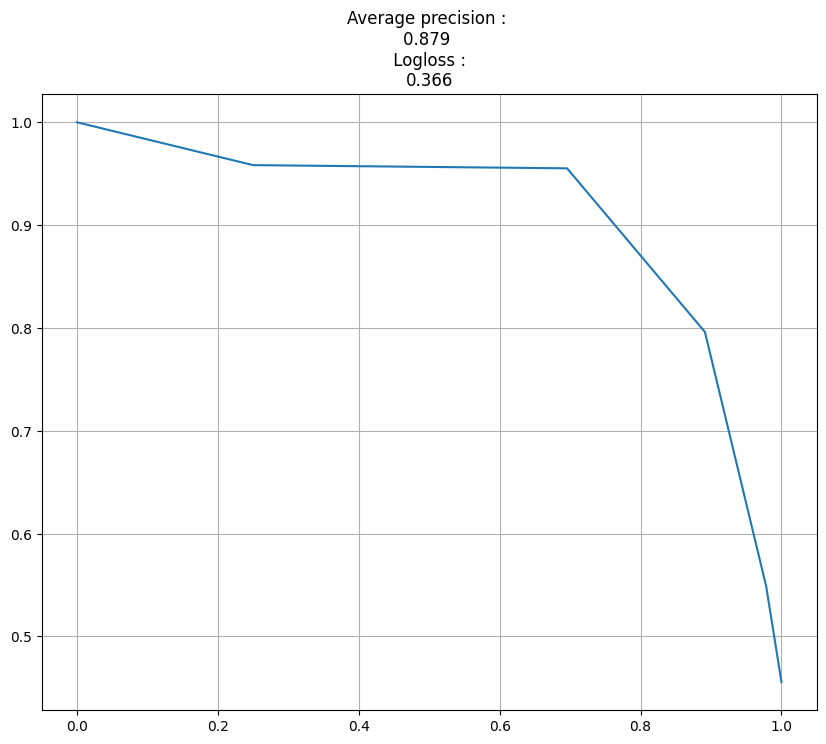

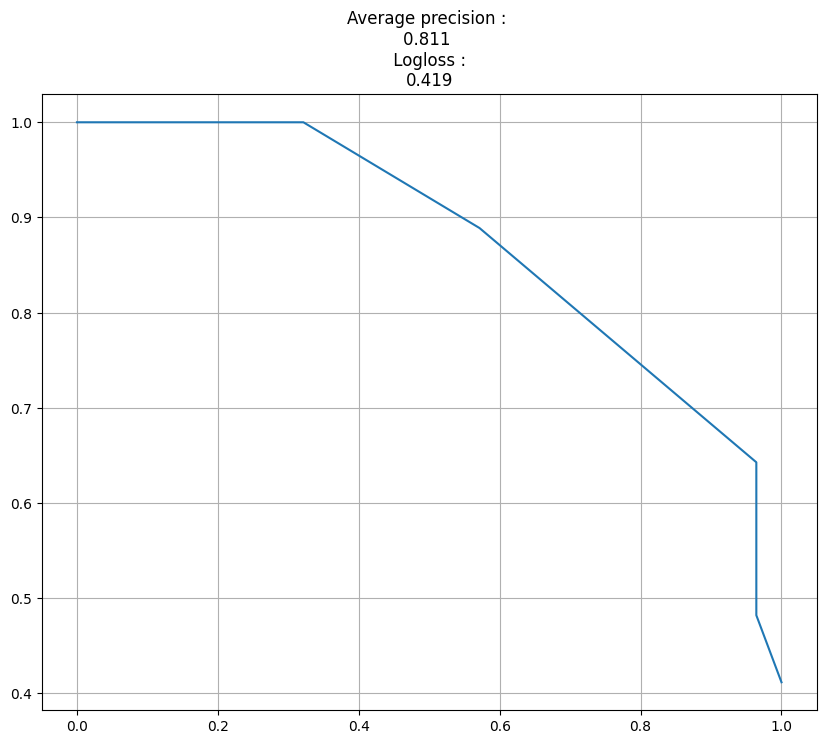

The Risk Score is:
1.                             the slope of the peak exercise ST segment < 1.5     -1 point(s) |   ...
2.                   number of major vessels (0-3) colored by flourosopy < 0.5     -1 point(s) | + ...
3.                                                         chest pain type_4.0      1 point(s) | + ...
4.                                                                    thal_7.0      1 point(s) | + ...
                                                                                         SCORE | =    
SCORE |  -2.0  |  -1.0  |   0.0  |
RISK  |   5.7% |  19.7% |  50.0% |
SCORE |   1.0  |   2.0  |
RISK  |  80.3% |  94.3% |


In [23]:
y_proba = RiskScoreClassifier_m.predict_prob(X_train_binarized.values)

precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.grid()
plt.show()

y_proba = RiskScoreClassifier_m.predict_prob(X_test_binarized.values)

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.grid()
plt.show()

X_featureNames = list(X_train_binarized.columns[:])

RiskScoreClassifier_m.reset_featureNames(X_featureNames)
RiskScoreClassifier_m.print_model_card()

In [24]:
ebm_model._binarizer.df_score_feature.sort_values(by='abs_contribution').tail(15)

,EBM_log_odds_contribution,lower_threshold,upper_threshold,category_value,feature,type,density,abs_contribution
binary_feature,,,,,,,,
exercise induced angina_0.0,-0.227448,None,None,0.0,exercise induced angina,categorical,132,30.023078
exercise induced angina_1.0,0.428901,None,None,1.0,exercise induced angina,categorical,70,30.023078
chest pain type_3.0,-0.567483,None,None,3.0,chest pain type,categorical,56,31.779024
serum cholestoral in mg/dl >= 265.5,0.49601,265.5,NaN,None,serum cholestoral in mg/dl,continuous,67,33.232651
oldpeak = ST depression induced by exercise relative to rest >= 1.35,0.513928,1.35,NaN,None,oldpeak = ST depression induced by exercise re...,continuous,74,38.030659
thal_3.0,-0.358553,None,None,3.0,thal,categorical,114,40.875011
1.5 <= the slope of the peak exercise ST segment < 2.5,0.455746,1.5,2.5,None,the slope of the peak exercise ST segment,continuous,92,41.928629
the slope of the peak exercise ST segment < 1.5,-0.439678,NaN,1.5,None,the slope of the peak exercise ST segment,continuous,97,42.648785
sex_0.0,-0.719099,None,None,0.0,sex,categorical,63,45.303209


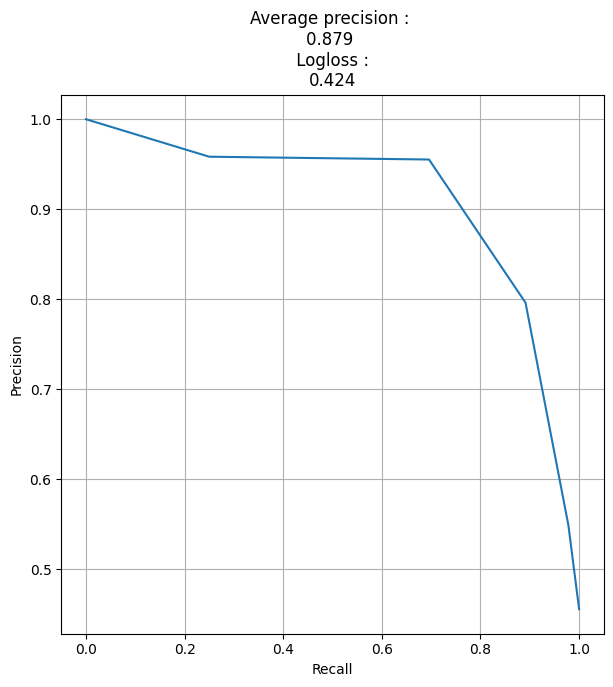

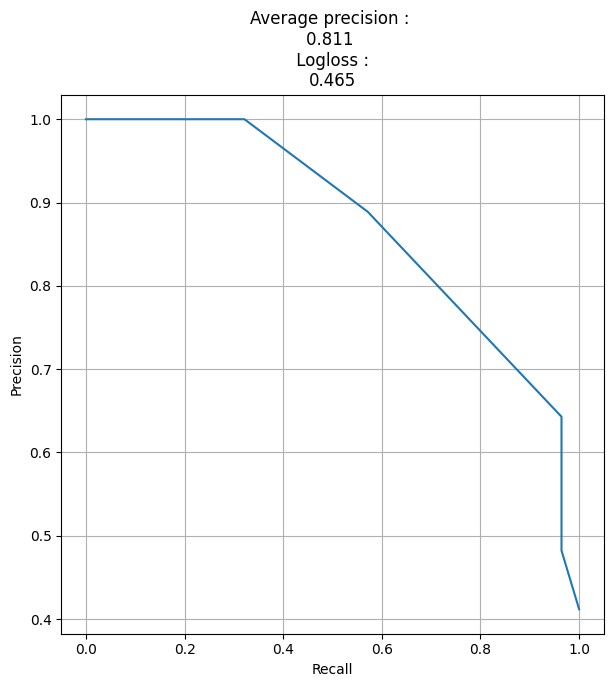

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss

y_proba = ebm_model.predict_proba(X_train)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_train.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_train.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_train.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


y_proba = ebm_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int), y_proba), 3)
logloss = np.round(log_loss(y_test.astype(int), y_proba), 3)
title_PR_curve = f"Average precision : \n{average_precision} \n Logloss : \n{logloss}"
plt.title(title_PR_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()